В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

Accuracy score on Train dataset: 0.87%
RMSE for Train: 0.36
F1 score on Train dataset: 0.63%
AUROC for Train: 0.88


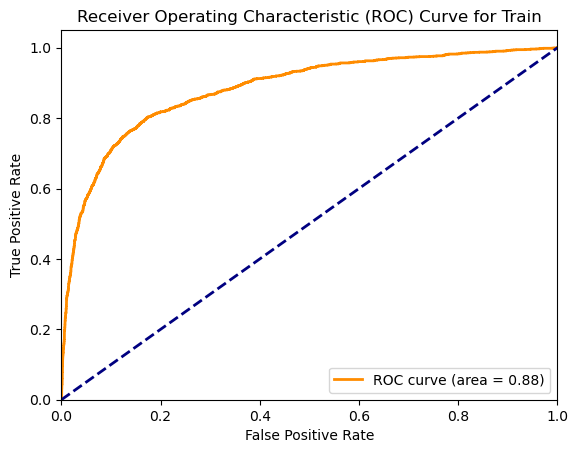

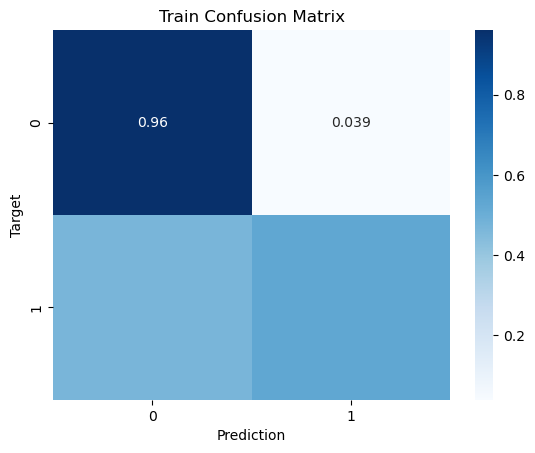

Accuracy score on Validation dataset: 0.87%
RMSE for Validation: 0.36
F1 score on Validation dataset: 0.61%
AUROC for Validation: 0.88


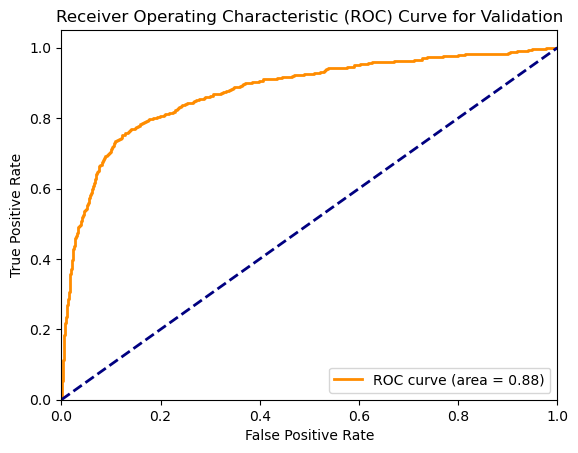

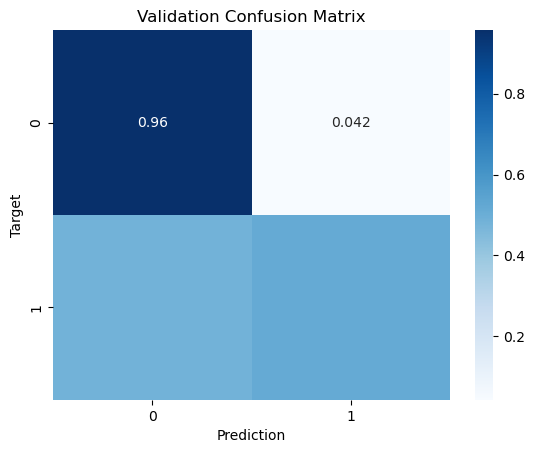

Accuracy score on Test dataset: 0.87%
RMSE for Test: 0.36
F1 score on Test dataset: 0.64%
AUROC for Test: 0.88


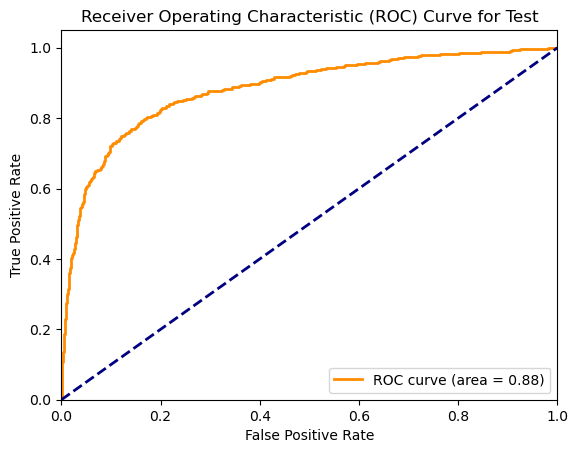

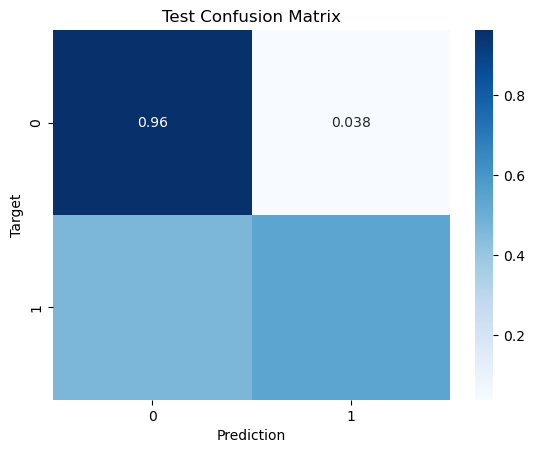

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler , OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, mean_squared_error

import joblib

#make main data frame
main_df = pd.read_csv('./bank-customer-churn-prediction-dlu/train.csv', index_col=0)

#print(main_df.head())

# Create training, validation and test sets
train_val_df, test_df = train_test_split(main_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

# Create inputs and targets
target_col = 'Exited'
input_data = main_df.drop(columns=[target_col])
input_cols = list(input_data.columns)

train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]
test_inputs, test_targets = test_df[input_cols], test_df[target_col]

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
category_cols = train_inputs.select_dtypes(include='object').columns.tolist()

numeric_cols.remove('CustomerId')
category_cols.remove('Surname')

# Create preprocessing pipelines for both numeric and categorical data
numeric_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
    ])

category_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')) #drop='first' 
    ])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transform, numeric_cols),
        ('cat', category_transform, category_cols)
    ])

# Create a pipeline that includes preprocessing and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
model_pipeline.fit(train_inputs, train_targets)

# Helper function to predict, compute accuracy & plot confusion matrix
def predict_and_plot(model, inputs, targets, name=''):

    preds = model.predict(inputs)
    probs = model.predict_proba(inputs)

    accuracy = accuracy_score(targets, preds)
    print(f"Accuracy score on {name} dataset: {accuracy:.2f}%")

    RMSE = mean_squared_error(targets, preds, squared=False)
    print(f'RMSE for {name}: {RMSE:.2f}')

    f1 = f1_score(targets, preds, pos_label=1.0)
    print(f"F1 score on {name} dataset: {f1:.2f}%")

    fpr, tpr, thresholds = roc_curve(targets, probs[:, 1], pos_label=1.0)
    roc_auc = auc(fpr, tpr)
    print(f'AUROC for {name}: {roc_auc:.2f}')
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

    cf = confusion_matrix(targets, preds, normalize='true')
    # Plot the confusion_matrix
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()

    return preds

# Evaluate on validation and test set
traine_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')
test_preds = predict_and_plot(model_pipeline, test_inputs, test_targets, 'Test')

bank_customer = {
    'model': model_pipeline,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': category_cols,
    'plot': predict_and_plot
}

# Save the trained model
joblib.dump(bank_customer, 'bank_customer_pipeline.joblib')

# Load the trained model
model_pipeline_loaded = joblib.load('bank_customer_pipeline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [2]:
import operator
from sklearn.preprocessing import PolynomialFeatures

Accuracy score on Train dataset: 0.89%
RMSE for Train: 0.33
F1 score on Train dataset: 0.69%
AUROC for Train: 0.92


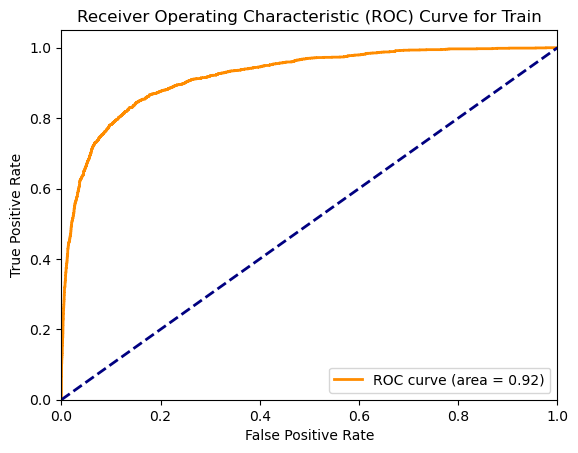

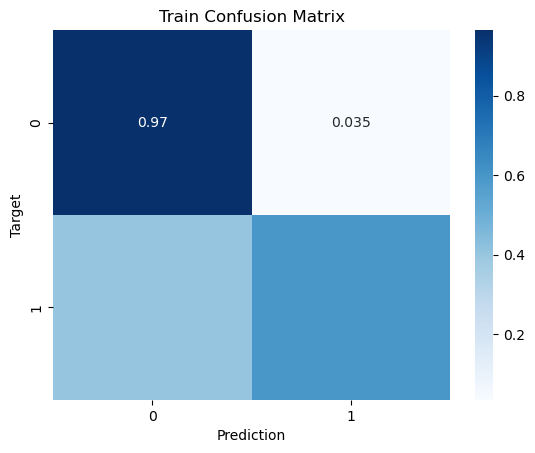

Accuracy score on Validation dataset: 0.89%
RMSE for Validation: 0.33
F1 score on Validation dataset: 0.68%
AUROC for Validation: 0.92


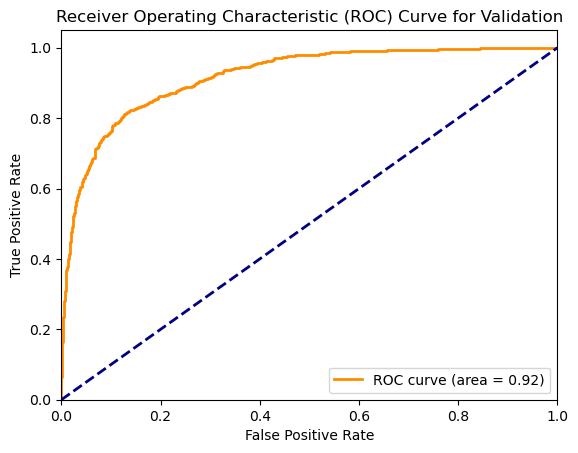

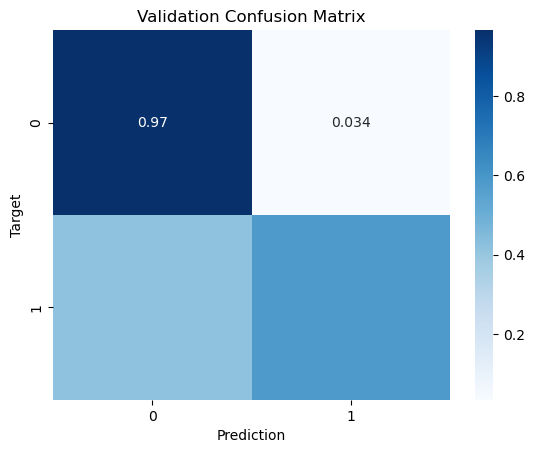

Accuracy score on Test dataset: 0.88%
RMSE for Test: 0.34
F1 score on Test dataset: 0.68%
AUROC for Test: 0.91


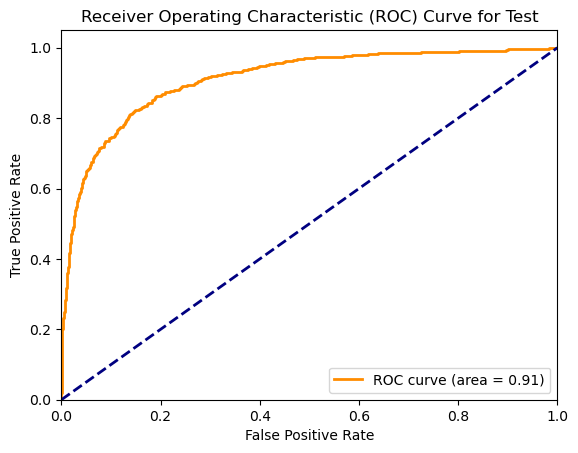

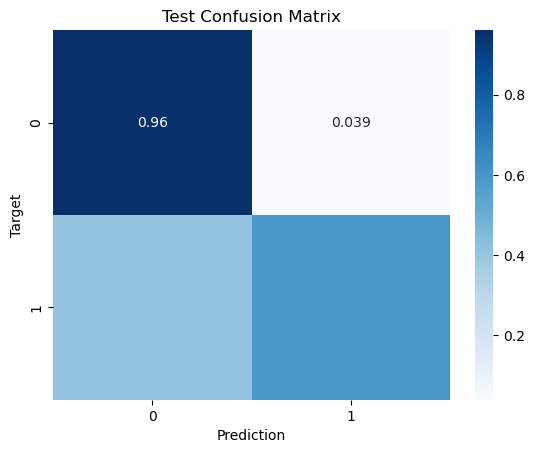

In [3]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('polinom_2',  PolynomialFeatures(degree=2, include_bias=False))
    ])

category_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')) #drop='first' 
    ])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transform, numeric_cols),
        ('cat', category_transform, category_cols)
    ])

# Create a pipeline that includes preprocessing and the model
model_pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
model_pipeline_2.fit(train_inputs, train_targets)

# Evaluate on validation and test set
traine_preds_2 = predict_and_plot(model_pipeline_2, train_inputs, train_targets, 'Train')
val_preds_2 = predict_and_plot(model_pipeline_2, val_inputs, val_targets, 'Validation')
test_preds_2 = predict_and_plot(model_pipeline_2, test_inputs, test_targets, 'Test')



В порівнянні з попередніми результатами я бачу, що значення метрик покращилось, тому можна сказати, що ця модель покращує тренування та ефективно працює на нових даних.

В нас покращилась середня квадратична помилка та збільшилась оцінка AROC, і результати однаково хороші як на тренувальному так і на тестовому, тому не можна сказати, що ми недоначили чи перенавчили модель 

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Accuracy score on Train dataset: 0.90%
RMSE for Train: 0.31
F1 score on Train dataset: 0.74%
AUROC for Train: 0.93


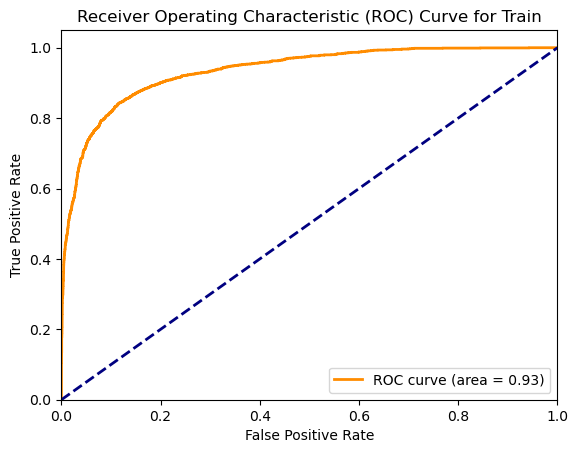

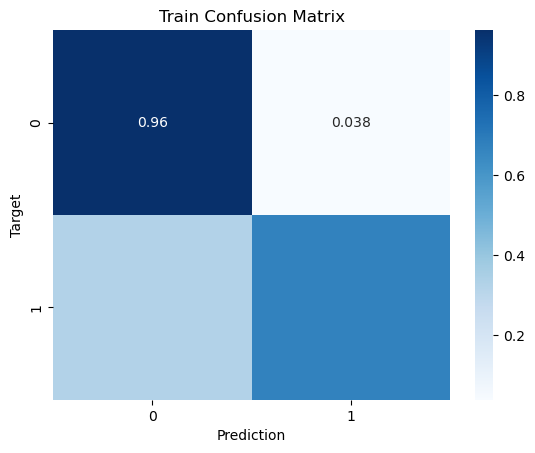

Accuracy score on Validation dataset: 0.90%
RMSE for Validation: 0.32
F1 score on Validation dataset: 0.72%
AUROC for Validation: 0.93


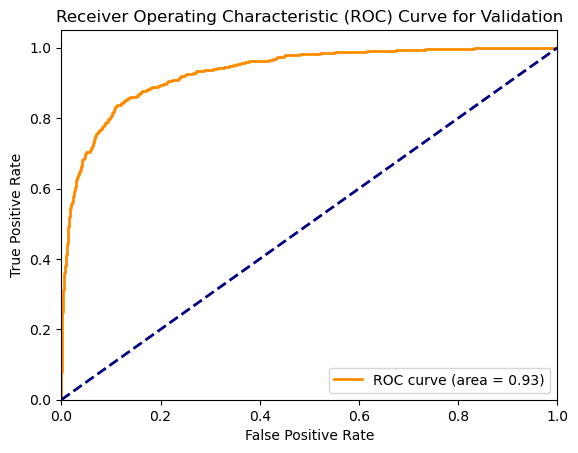

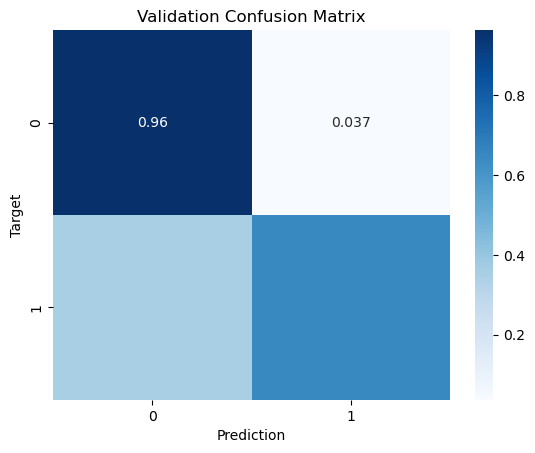

Accuracy score on Test dataset: 0.89%
RMSE for Test: 0.33
F1 score on Test dataset: 0.71%
AUROC for Test: 0.92


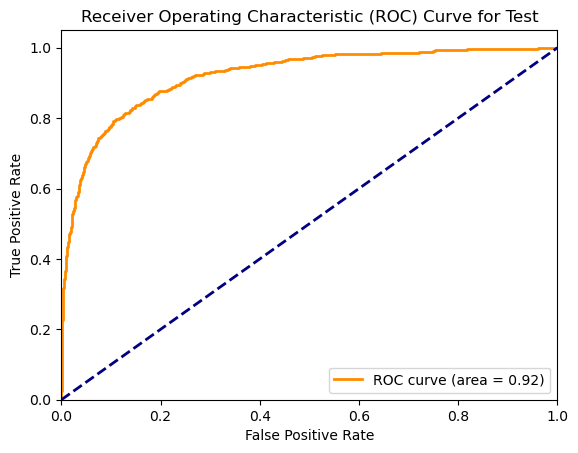

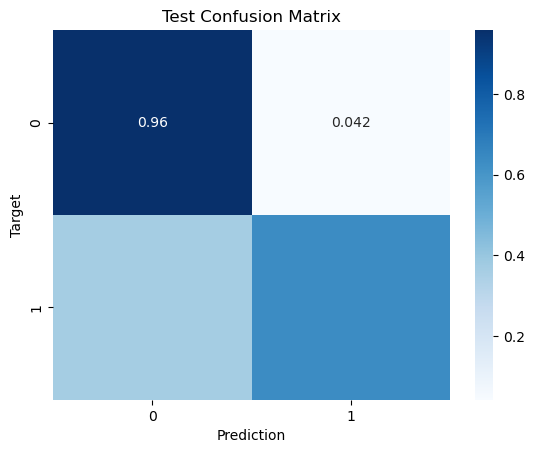

In [4]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('polinom_4',  PolynomialFeatures(degree=4, include_bias=False))
    ])

category_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')) #drop='first' 
    ])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transform, numeric_cols),
        ('cat', category_transform, category_cols)
    ])

# Create a pipeline that includes preprocessing and the model
model_pipeline_4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
model_pipeline_4.fit(train_inputs, train_targets)

# Evaluate on validation and test set
traine_preds_4 = predict_and_plot(model_pipeline_4, train_inputs, train_targets, 'Train')
val_preds_4 = predict_and_plot(model_pipeline_4, val_inputs, val_targets, 'Validation')
test_preds_4 = predict_and_plot(model_pipeline_4, test_inputs, test_targets, 'Test')



Результати покрашились ще більше. Ми вже маємо дуже чудову оцінку, як на тренувальних, так і на валідаційних даних. Модель чудово навчає дані.

Запишу результати в файл для додавання даних в конкурс

In [5]:
test_bank_df = pd.read_csv('./bank-customer-churn-prediction-dlu/test.csv')
test_bank_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
9996,24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
9997,24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72
9998,24998,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09


In [6]:
# Train the model
test_bank_df['Exited'] = model_pipeline_4.predict_proba(test_bank_df)[:,1]
test_bank_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.077678
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.024387
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.064476
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.425823
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.030195


In [7]:
#Save the result to file
sample_submission_df = pd.read_csv('./bank-customer-churn-prediction-dlu/sample_submission.csv')
sample_submission_df['Exited'] = test_bank_df['Exited'].round(2)
sample_submission_df.to_csv('submission_log_reg_5.csv', index=False)

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Зчитайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [9]:
reg_df = pd.read_csv('regression_data.csv')
reg_df

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013
...,...,...,...,...,...,...
124,1.402794,0.586857,-1.401851,0.791032,-0.909387,39.626185
125,-0.288659,-0.827231,0.322719,-1.002529,-0.018513,-50.585687
126,-1.407464,-0.213447,-0.718444,0.232050,-1.448084,13.719861
127,1.353872,1.237816,-0.114540,-0.469176,-1.713135,-23.851350


Text(0.5, 1.0, 'Target')

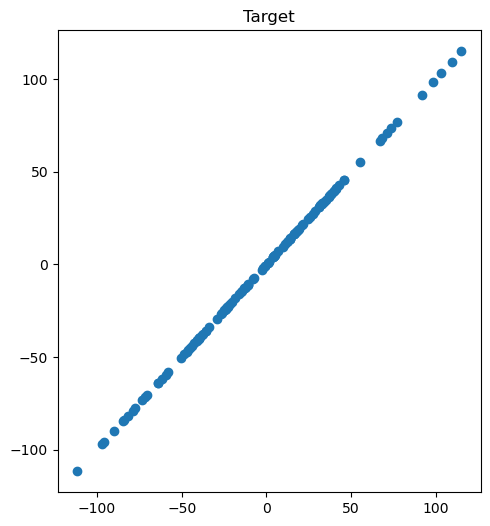

In [10]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(reg_df['target'], reg_df['target'])
plt.title('Target')

In [11]:
reg_df.info()
reg_df.target.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  129 non-null    float64
 1   feature_2  129 non-null    float64
 2   feature_3  129 non-null    float64
 3   feature_4  129 non-null    float64
 4   feature_5  129 non-null    float64
 5   target     129 non-null    float64
dtypes: float64(6)
memory usage: 6.2 KB


target
 28.938854    1
 1.322326     1
 98.496591    1
 5.120619     1
-12.536428    1
             ..
 33.755611    1
 17.700624    1
-41.297167    1
-0.706706     1
 12.870252    1
Name: count, Length: 129, dtype: int64

In [12]:
train_reg_df, test_reg_df = train_test_split(reg_df, test_size=0.2, random_state=42)

target_reg_col = 'target'
input_reg_data = reg_df.drop(columns=[target_reg_col])
input_reg_col = list(input_reg_data.columns)

train_reg_inputs, train_reg_target = train_reg_df[input_reg_col], train_reg_df[target_reg_col]
test_reg_inputs, test_reg_target = test_reg_df[input_reg_col], test_reg_df[target_reg_col]

In [13]:
def train_lin_vs_poly_reg_and_plot(X_train, X_val, y_train, y_val, degree):
  # Звичайна лінійна регресія
  lin_reg = LinearRegression()
  lin_reg.fit(X_train, y_train)
  y_pred_train_lin = lin_reg.predict(X_train)
  y_pred_val_lin = lin_reg.predict(X_val)

  # Поліноміальна регресія
  poly_features = PolynomialFeatures(degree=degree)
  X_train_poly = poly_features.fit_transform(X_train)
  X_val_poly = poly_features.transform(X_val)

  print(f'В оригіналній матриці {X_train.shape[1]} ознак.')
  print(f'В матриці Х з поліноміальними ознаками {X_train_poly.shape[1]} ознак.\n')

  poly_reg = LinearRegression()
  poly_reg.fit(X_train_poly, y_train)
  y_pred_train_poly = poly_reg.predict(X_train_poly)
  y_pred_val_poly = poly_reg.predict(X_val_poly)

  # Оцінка моделей

  rmse_lin_train = mean_squared_error(y_train, y_pred_train_lin, squared=False)
  rmse_poly_train = mean_squared_error(y_train, y_pred_train_poly, squared=False)

  rmse_lin_val = mean_squared_error(y_val, y_pred_val_lin, squared=False)
  rmse_poly_val = mean_squared_error(y_val, y_pred_val_poly, squared=False)


  print(f"Train RMSE for Linear Regression: {np.sqrt(rmse_lin_train):.3f}")
  print(f"Train RMSE for Polynomial Regression (degree {degree}): {np.sqrt(rmse_poly_train):.3f}\n")
  
  print(f"Test RMSE for Linear Regression: {np.sqrt(rmse_lin_val):.3f}")
  print(f"Test RMSE for Polynomial Regression (degree {degree}): {np.sqrt(rmse_poly_val):.3f}")    
  

  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.scatter(y_train, y_pred_train_poly, alpha=0.5, label='Poly model data')
  plt.scatter(y_train, y_pred_train_lin, alpha=0.5, label='Lin model data')
  plt.legend(loc="lower right")
  plt.title('Train Poly vs Lin')

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.scatter(y_val, y_pred_val_poly, alpha=0.5, label='Poly model data')
  plt.scatter(y_val, y_pred_val_lin, alpha=0.5, label='Lin model data')
  plt.legend(loc="lower right")
  plt.title('Test Poly vs Lin')


  plt.show()

В оригіналній матриці 5 ознак.
В матриці Х з поліноміальними ознаками 252 ознак.

Train RMSE for Linear Regression: 1.033
Train RMSE for Polynomial Regression (degree 5): 0.000

Test RMSE for Linear Regression: 0.940
Test RMSE for Polynomial Regression (degree 5): 5.425


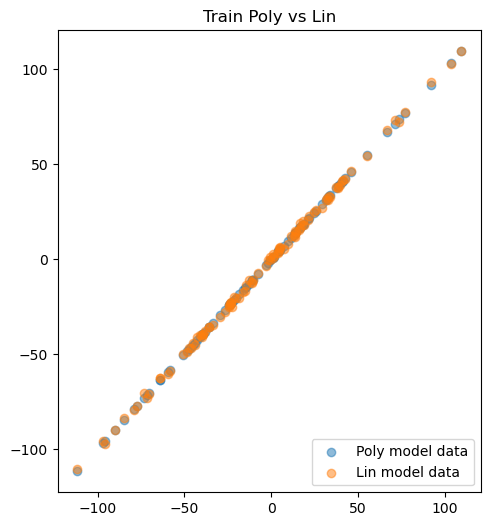

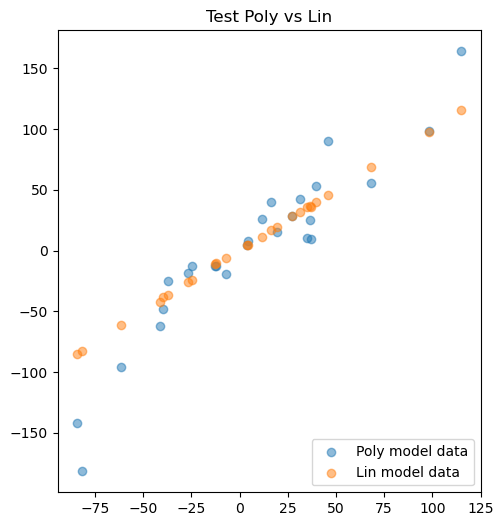

In [14]:
degree = 5
train_lin_vs_poly_reg_and_plot(train_reg_inputs, test_reg_inputs, train_reg_target, test_reg_target, degree)

Можу зробити висновок, що модель з поліноміальними ознаками перенавчина, так як передбачення на тренувальних даних повністю співпали з справжніми, а на тестових вже не так чітко, на відміну від лінійної, яка непогано справилась і з тестовими даними 

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лог регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [15]:
poly_features = PolynomialFeatures(degree=20)
X_train_poly = poly_features.fit_transform(train_reg_inputs)
X_val_poly = poly_features.transform(test_reg_inputs)

In [16]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    LinearRegression(),
    Ridge(),
    Ridge(alpha=0.1),
    Lasso(alpha=0.1),
    ElasticNet(),
    ElasticNet(alpha=0.1, l1_ratio=0.5)
]

In [17]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_metrics = mean_squared_error(y_train, y_train_pred, squared=False).round(6)
    val_metrics = mean_squared_error(y_val, y_val_pred, squared=False).round(6)

    return dict(train=train_metrics, val=val_metrics)

In [18]:
import warnings

warnings.filterwarnings("ignore")
for model in models:
    model.fit(X_train_poly, train_reg_target)
    eval_results  = evaluate_model(model, X_train_poly, train_reg_target, X_val_poly, test_reg_target)
    print(f'{str(model)}: {eval_results}\n')

LinearRegression(): {'train': 0.00497, 'val': 102859.379482}

Ridge(): {'train': 29.890289, 'val': 20652.503835}

Ridge(alpha=0.1): {'train': 29.890289, 'val': 20652.503835}

Lasso(alpha=0.1): {'train': 0.676908, 'val': 10.680931}

ElasticNet(): {'train': 10.159852, 'val': 1526.820921}

ElasticNet(alpha=0.1): {'train': 3.603338, 'val': 273.20412}



По результатам бачимо, по при поліміальних ознаках 20 степеня моделі занадто перенавчають дані і на тестових даних ми бачимо неймовірно високі значення помилок, окрім моделі Lasso яка показує гарні результати як на тренувальних так і на тестових значеннях

In [19]:
y_train_pred_las = model.predict(X_train_poly)
y_test_pred_las = model.predict(X_val_poly)


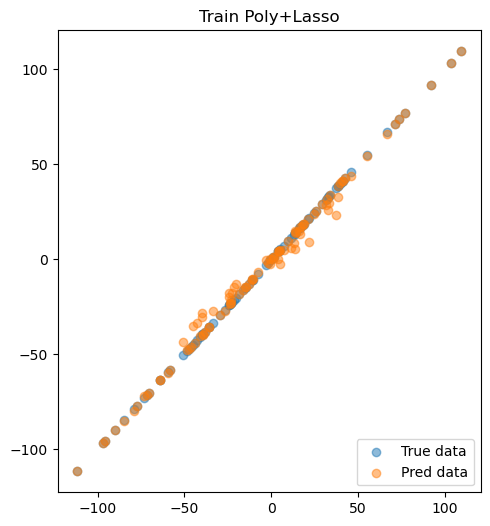

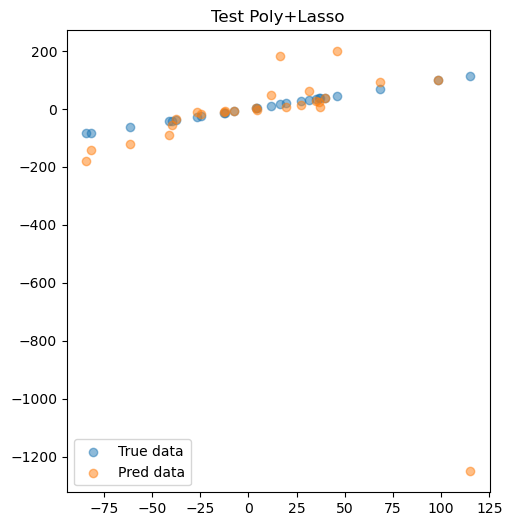

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(train_reg_target, train_reg_target, alpha=0.5, label='True data')
plt.scatter(train_reg_target, y_train_pred_las, alpha=0.5, label='Pred data')
plt.legend(loc="lower right")
plt.title('Train Poly+Lasso')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(test_reg_target, test_reg_target, alpha=0.5, label='True data')
plt.scatter(test_reg_target, y_test_pred_las, alpha=0.5, label='Pred data')
plt.title('Test Poly+Lasso')
plt.legend(loc="lower left")
plt.show()